In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('cardio_train.csv', sep=';')

In [4]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


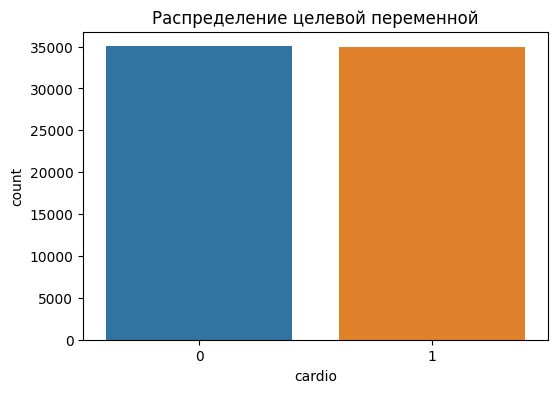

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='cardio', data=df)
plt.title('Распределение целевой переменной')
plt.show()

In [47]:
df['age_new'] = df['age']/365

In [48]:
df = df.drop(columns='id')
df = df.drop(columns='age')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       70000 non-null  int64  
 1   height       70000 non-null  int64  
 2   weight       70000 non-null  float64
 3   ap_hi        70000 non-null  int64  
 4   ap_lo        70000 non-null  int64  
 5   cholesterol  70000 non-null  int64  
 6   gluc         70000 non-null  int64  
 7   smoke        70000 non-null  int64  
 8   alco         70000 non-null  int64  
 9   active       70000 non-null  int64  
 10  cardio       70000 non-null  int64  
 11  age_new      70000 non-null  float64
dtypes: float64(2), int64(10)
memory usage: 6.4 MB


In [50]:
random_state = 42
target = 'cardio'

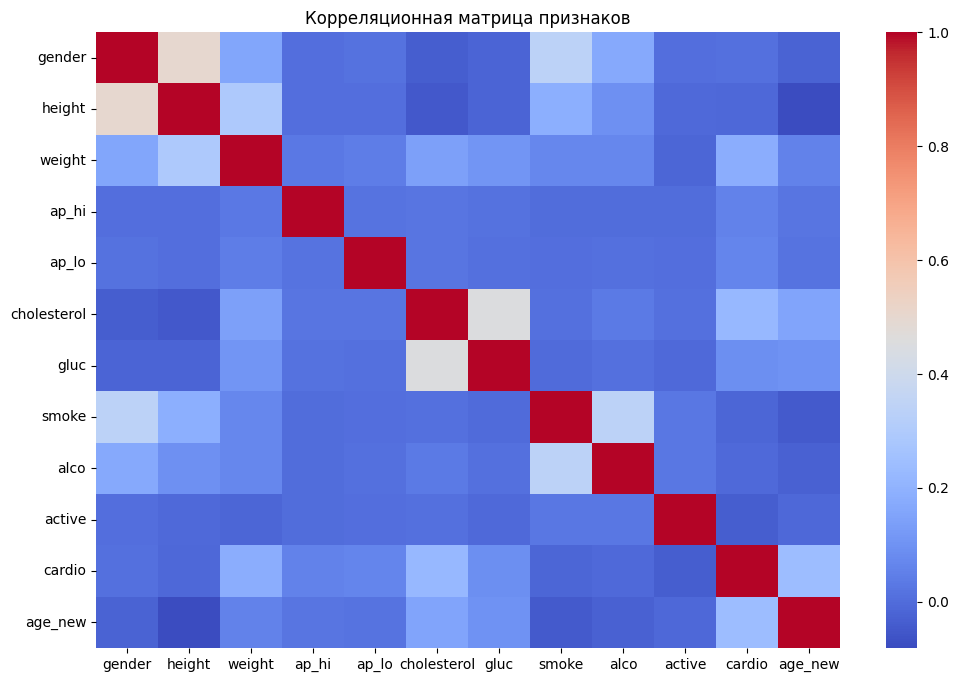

In [51]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', )
plt.title("Корреляционная матрица признаков")
plt.show()

In [52]:
train, test = train_test_split(df, test_size=0.2, random_state=random_state)
train, val = train_test_split(train, test_size=0.25, random_state=random_state)

In [53]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')
val.to_parquet('val.parquet')

# FIRST

In [82]:
train = pd.read_parquet('train.parquet')
val = pd.read_parquet('val.parquet')
test = pd.read_parquet('test.parquet')

In [83]:
model = LogisticRegression()
model.fit(train.drop(columns=target), train[target])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [84]:
print(f"TRAIN : {roc_auc_score(train[target], model.predict_proba(train.drop(columns=[target]))[:, 1])}")
print(f"VAL : {roc_auc_score(val[target], model.predict_proba(val.drop(columns=[target]))[:, 1])}")
print(f"TEST : {roc_auc_score(test[target], model.predict_proba(test.drop(columns=[target]))[:, 1])}")

TRAIN : 0.7610545501502037
VAL : 0.7694420217648299
TEST : 0.7690343620601661


In [85]:
print(f"TRAIN : {f1_score(train[target], model.predict(train.drop(columns=[target])))}")
print(f"VAL : {f1_score(val[target], model.predict(val.drop(columns=[target])))}")
print(f"TEST : {f1_score(test[target], model.predict(test.drop(columns=[target])))}")

TRAIN : 0.6857270938659626
VAL : 0.6973684210526315
TEST : 0.6961350510884051


In [86]:
y_pred = model.predict(test.drop(columns=[target]))

accuracy = accuracy_score(test[target], y_pred)
precision = precision_score(test[target], y_pred)
recall = recall_score(test[target], y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.71
Precision: 0.72
Recall: 0.67


In [87]:
feature_importance = model.coef_[0]

feature_names = test.drop(columns=[target]).columns
importance_table = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_table)

        Feature  Importance
5   cholesterol    0.525444
0        gender    0.290474
10      age_new    0.039048
3         ap_hi    0.027938
2        weight    0.018630
4         ap_lo    0.000288
7         smoke   -0.028517
1        height   -0.046199
8          alco   -0.067243
6          gluc   -0.164739
9        active   -0.251236


# SECOND

In [88]:
train = train.drop(columns = ['active', 'height', 'alco', 'smoke', 'gluc'])
val = val.drop(columns = ['active', 'height', 'alco', 'smoke', 'gluc'])
test = test.drop(columns = ['active', 'height', 'alco', 'smoke', 'gluc'])

In [89]:
model = LogisticRegression()
model.fit(train.drop(columns=target), train[target])

LogisticRegression()

In [90]:
print(f"TRAIN : {roc_auc_score(train[target], model.predict_proba(train.drop(columns=[target]))[:, 1])}")
print(f"VAL : {roc_auc_score(val[target], model.predict_proba(val.drop(columns=[target]))[:, 1])}")
print(f"TEST : {roc_auc_score(test[target], model.predict_proba(test.drop(columns=[target]))[:, 1])}")

TRAIN : 0.7762167998332936
VAL : 0.7865272244050998
TEST : 0.7805273346109426


In [91]:
print(f"TRAIN : {f1_score(train[target], model.predict(train.drop(columns=[target])))}")
print(f"VAL : {f1_score(val[target], model.predict(val.drop(columns=[target])))}")
print(f"TEST : {f1_score(test[target], model.predict(test.drop(columns=[target])))}")

TRAIN : 0.699214953271028
VAL : 0.7063722209829727
TEST : 0.7048813255709807


In [92]:
y_pred = model.predict(test.drop(columns=[target]))

accuracy = accuracy_score(test[target], y_pred)
precision = precision_score(test[target], y_pred)
recall = recall_score(test[target], y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.72
Precision: 0.74
Recall: 0.67


In [93]:
feature_importance = model.coef_[0]

feature_names = test.drop(columns=[target]).columns
importance_table = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_table)

       Feature  Importance
4  cholesterol    0.477391
5      age_new    0.054655
2        ap_hi    0.032968
1       weight    0.014816
3        ap_lo    0.000256
0       gender   -0.056709


# THIRD

In [94]:
x_train = train.drop(columns=target)
y_train = train[target]

x_val = val.drop(columns=target)
y_val = val[target]

x_test = test.drop(columns=target)
y_test = test[target]

In [95]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(x_train)
val_scaled = scaler.transform(x_val)
test_scaled = scaler.transform(x_test)

poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(train_scaled)
x_val_poly = poly.transform(val_scaled)
x_test_poly = poly.transform(test_scaled)

In [97]:
model = LogisticRegression()
model.fit(x_train_poly, train[target])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [98]:
print(f"TRAIN : {roc_auc_score(train[target], model.predict_proba(x_train_poly)[:, 1])}")
print(f"VAL : {roc_auc_score(val[target], model.predict_proba(x_val_poly)[:, 1])}")
print(f"TEST : {roc_auc_score(test[target], model.predict_proba(x_test_poly)[:, 1])}")

TRAIN : 0.7806903705493728
VAL : 0.7908303319827893
TEST : 0.7841639065225008


In [99]:
print(f"TRAIN : {f1_score(train[target], model.predict(x_train_poly))}")
print(f"VAL : {f1_score(val[target], model.predict(x_val_poly))}")
print(f"TEST : {f1_score(test[target], model.predict(x_test_poly))}")

TRAIN : 0.7107917917425324
VAL : 0.7202520515826495
TEST : 0.7141279540602223


In [100]:
y_pred = model.predict(x_test_poly)

accuracy = accuracy_score(test[target], y_pred)
precision = precision_score(test[target], y_pred)
recall = recall_score(test[target], y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.72
Precision: 0.74
Recall: 0.69
